# Data 4 Good Challenge: Team 15

The following code is our final submission code of the Data 4 Good Challenge 2022.

A more in depth discussion is given in the following blog post: https://medium.com/p/b84e49e6ba06

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import geopandas as gpd
import folium
#import mapclassify
from geopandas import GeoDataFrame
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, plot_importance
from sklearn.preprocessing import OneHotEncoder
import shap
from sklearn.cluster import KMeans

# Setting up the data

In [229]:
sector_geojson = gpd.read_file('data/NIS_Sectoren.geojson')
sector_geojson_GEO = sector_geojson[['NAAM','geometry']]

df = pd.read_csv('data/Data1_demographic_sector.csv')#, index_col = 'Year')
df['statistical_sector'] = df['statistical_sector'].str.upper()
df = pd.merge(df, sector_geojson_GEO, how='left', left_on='statistical_sector', right_on='NAAM')
df = df.drop(['ID', 'NAAM'],axis=1)


df_Geo = GeoDataFrame(df)

## Inspecting NaN-values
We will drop columns with more than 50 NaN's, interpolate all columns related to people and set to zero those related to commercial activities

In [232]:
for i, el in enumerate(df_Geo.isna().sum()):
    print(str(df_Geo.columns.tolist()[i]) +": " + str(el))

statistical_sector: 0
n_trees: 0
n_benches: 0
n_trashcans: 0
area_in_ha: 0
total_number_of_inhabitants: 3
population_density_per_km2: 3
men: 3
women: 4
population_0_17_year_olds: 6
population_20_39_year_olds: 4
population_40_59_year_olds: 4
population_60_79_year_olds: 4
population_80_year_olds: 17
births: 52
deaths: 68
natural_growth_b_d: 0
total_growth: 0
elderly_dependency_ratio: 4
youth_dependency_ratio: 6
caregiving_ratio: 5
dependency_coefficient: 6
family_care_index: 17
non_belgian_current_nationality_w_r_t_to_residents: 6
non_belgian_origin_w_r_t_to_inhabitants: 4
private_households: 4
households_without_lipro_children: 4
multi_person_households_with_at_least_1_minor_lipro_child: 8
multi_person_households_with_only_minor_lipro_child_ren: 18
household_1_person: 5
household_2_persons: 5
household_3_persons: 10
household_4_persons: 16
household_5_persons: 28
living_alone_w_r_t_to_private_households: 5
household_without_lipro_children_w_r_t_private_households: 3
multi_person_househo

In [233]:
df_Geo_dropna = df_Geo.dropna(axis=1, thresh=50)
for i, el in enumerate(df_Geo_dropna.isna().sum()):
    if el > 0:
        print(str(df_Geo_dropna.columns.tolist()[i]) +": " + str(el))

total_number_of_inhabitants: 3
population_density_per_km2: 3
men: 3
women: 4
population_0_17_year_olds: 6
population_20_39_year_olds: 4
population_40_59_year_olds: 4
population_60_79_year_olds: 4
population_80_year_olds: 17
births: 52
deaths: 68
elderly_dependency_ratio: 4
youth_dependency_ratio: 6
caregiving_ratio: 5
dependency_coefficient: 6
family_care_index: 17
non_belgian_current_nationality_w_r_t_to_residents: 6
non_belgian_origin_w_r_t_to_inhabitants: 4
private_households: 4
households_without_lipro_children: 4
multi_person_households_with_at_least_1_minor_lipro_child: 8
multi_person_households_with_only_minor_lipro_child_ren: 18
household_1_person: 5
household_2_persons: 5
household_3_persons: 10
household_4_persons: 16
household_5_persons: 28
living_alone_w_r_t_to_private_households: 5
household_without_lipro_children_w_r_t_private_households: 3
multi_person_households_with_at_least_1_minor_lipro_child_w_r_t_private_households: 8
single_parent_household_with_min_1_minor_lipro_

In [234]:
mean_columns = ['total_number_of_inhabitants', 'population_density_per_km2', 'men', 'women', 'population_0_17_year_olds', 'population_20_39_year_olds', 'population_40_59_year_olds', 'population_60_79_year_olds', 'population_80_year_olds', 'births', 'deaths', 'elderly_dependency_ratio', 'youth_dependency_ratio', 'caregiving_ratio', 'dependency_coefficient', 'family_care_index', 'non_belgian_current_nationality_w_r_t_to_residents', 'non_belgian_origin_w_r_t_to_inhabitants', 'private_households', 'households_without_lipro_children', 'multi_person_households_with_at_least_1_minor_lipro_child', 'multi_person_households_with_only_minor_lipro_child_ren', 'household_1_person', 'household_2_persons', 'household_3_persons', 'household_4_persons', 'household_5_persons', 'living_alone_w_r_t_to_private_households', 'household_without_lipro_children_w_r_t_private_households', 'multi_person_households_with_at_least_1_minor_lipro_child_w_r_t_private_households', 'single_parent_household_with_min_1_minor_lipro_child_vs_household_with_min_1_minor_lipro_child', 'nwwz_unemployed_jobseekers_w_r_t_inhabitants_18_64_yo', 'nwwz_unemployed_jobseekers', 'nwwz_short_term_unemployed_jobseekers', 'nwwz_long_term_unemployed_jobseekers', 'nwwz_very_long_term_unemployed_jobseekers', 'renters_w_r_t_households_with_known_title_of_ownership', 'persons_with_an_increased_allowance', 'persons_with_an_increased_allowance_w_r_t_persons_on_health_insurance', 'average_net_taxable_income_per_resident', 'preschool_students', 'elementary_school_students', 'secondary_school_students', 'indicator_pupils_primary_education_percent', 'indicator_pupils_secondary_education_percent', 'education_deprivation_indicator_value_primary_education_ratio', 'education_deprivation_indicator_value_secondary_education_ratio', 'geometry']

zero_columns = ['commercial_properties', 'commercial_properties_per_1000_inhabitants', 'stores_food_products', 'stores_personal_care', 'stores_clothing_and_fashion', 'stores_household_goods', 'stores_leisure', 'stores_in_and_around_the_house', 'stores_brown_and_white_goods', 'stores_car_and_bicycle', 'stores_do_it_yourself', 'stores_others', 'bars_and_restaurants', 'consumer_oriented_services_culture', 'consumer_oriented_services_transportation_and_fuels', 'consumer_oriented_services_recreation', 'consumer_oriented_services_others', 'commercial_properties_vacant_incl_renovation_until_2019', 'vacant_commercial_properties_w_r_t_commercial_properties_percent', 'stores_daily_goods_w_r_t_to_stores', 'residential_units_in_apartments', 'residential_units_in_individual_housing']

In [235]:
df_fillna = df_Geo_dropna
df_fillna[mean_columns] = df_Geo_dropna[mean_columns].fillna(df_Geo_dropna[mean_columns].mean())
df_fillna[zero_columns] = df_Geo_dropna[zero_columns].fillna(0)

In [236]:
X = df_fillna.drop(labels =["n_benches", "geometry", "statistical_sector"], axis=1)
y = df_Geo["n_benches"]

# LightGBM
A gradient boosted tree is trained and the model is inspected with respect to feature importance and shapley values

In [237]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [238]:
model = LGBMRegressor(max_depth=10)

In [239]:
model.fit(X_train, y_train)

LGBMRegressor(max_depth=10)

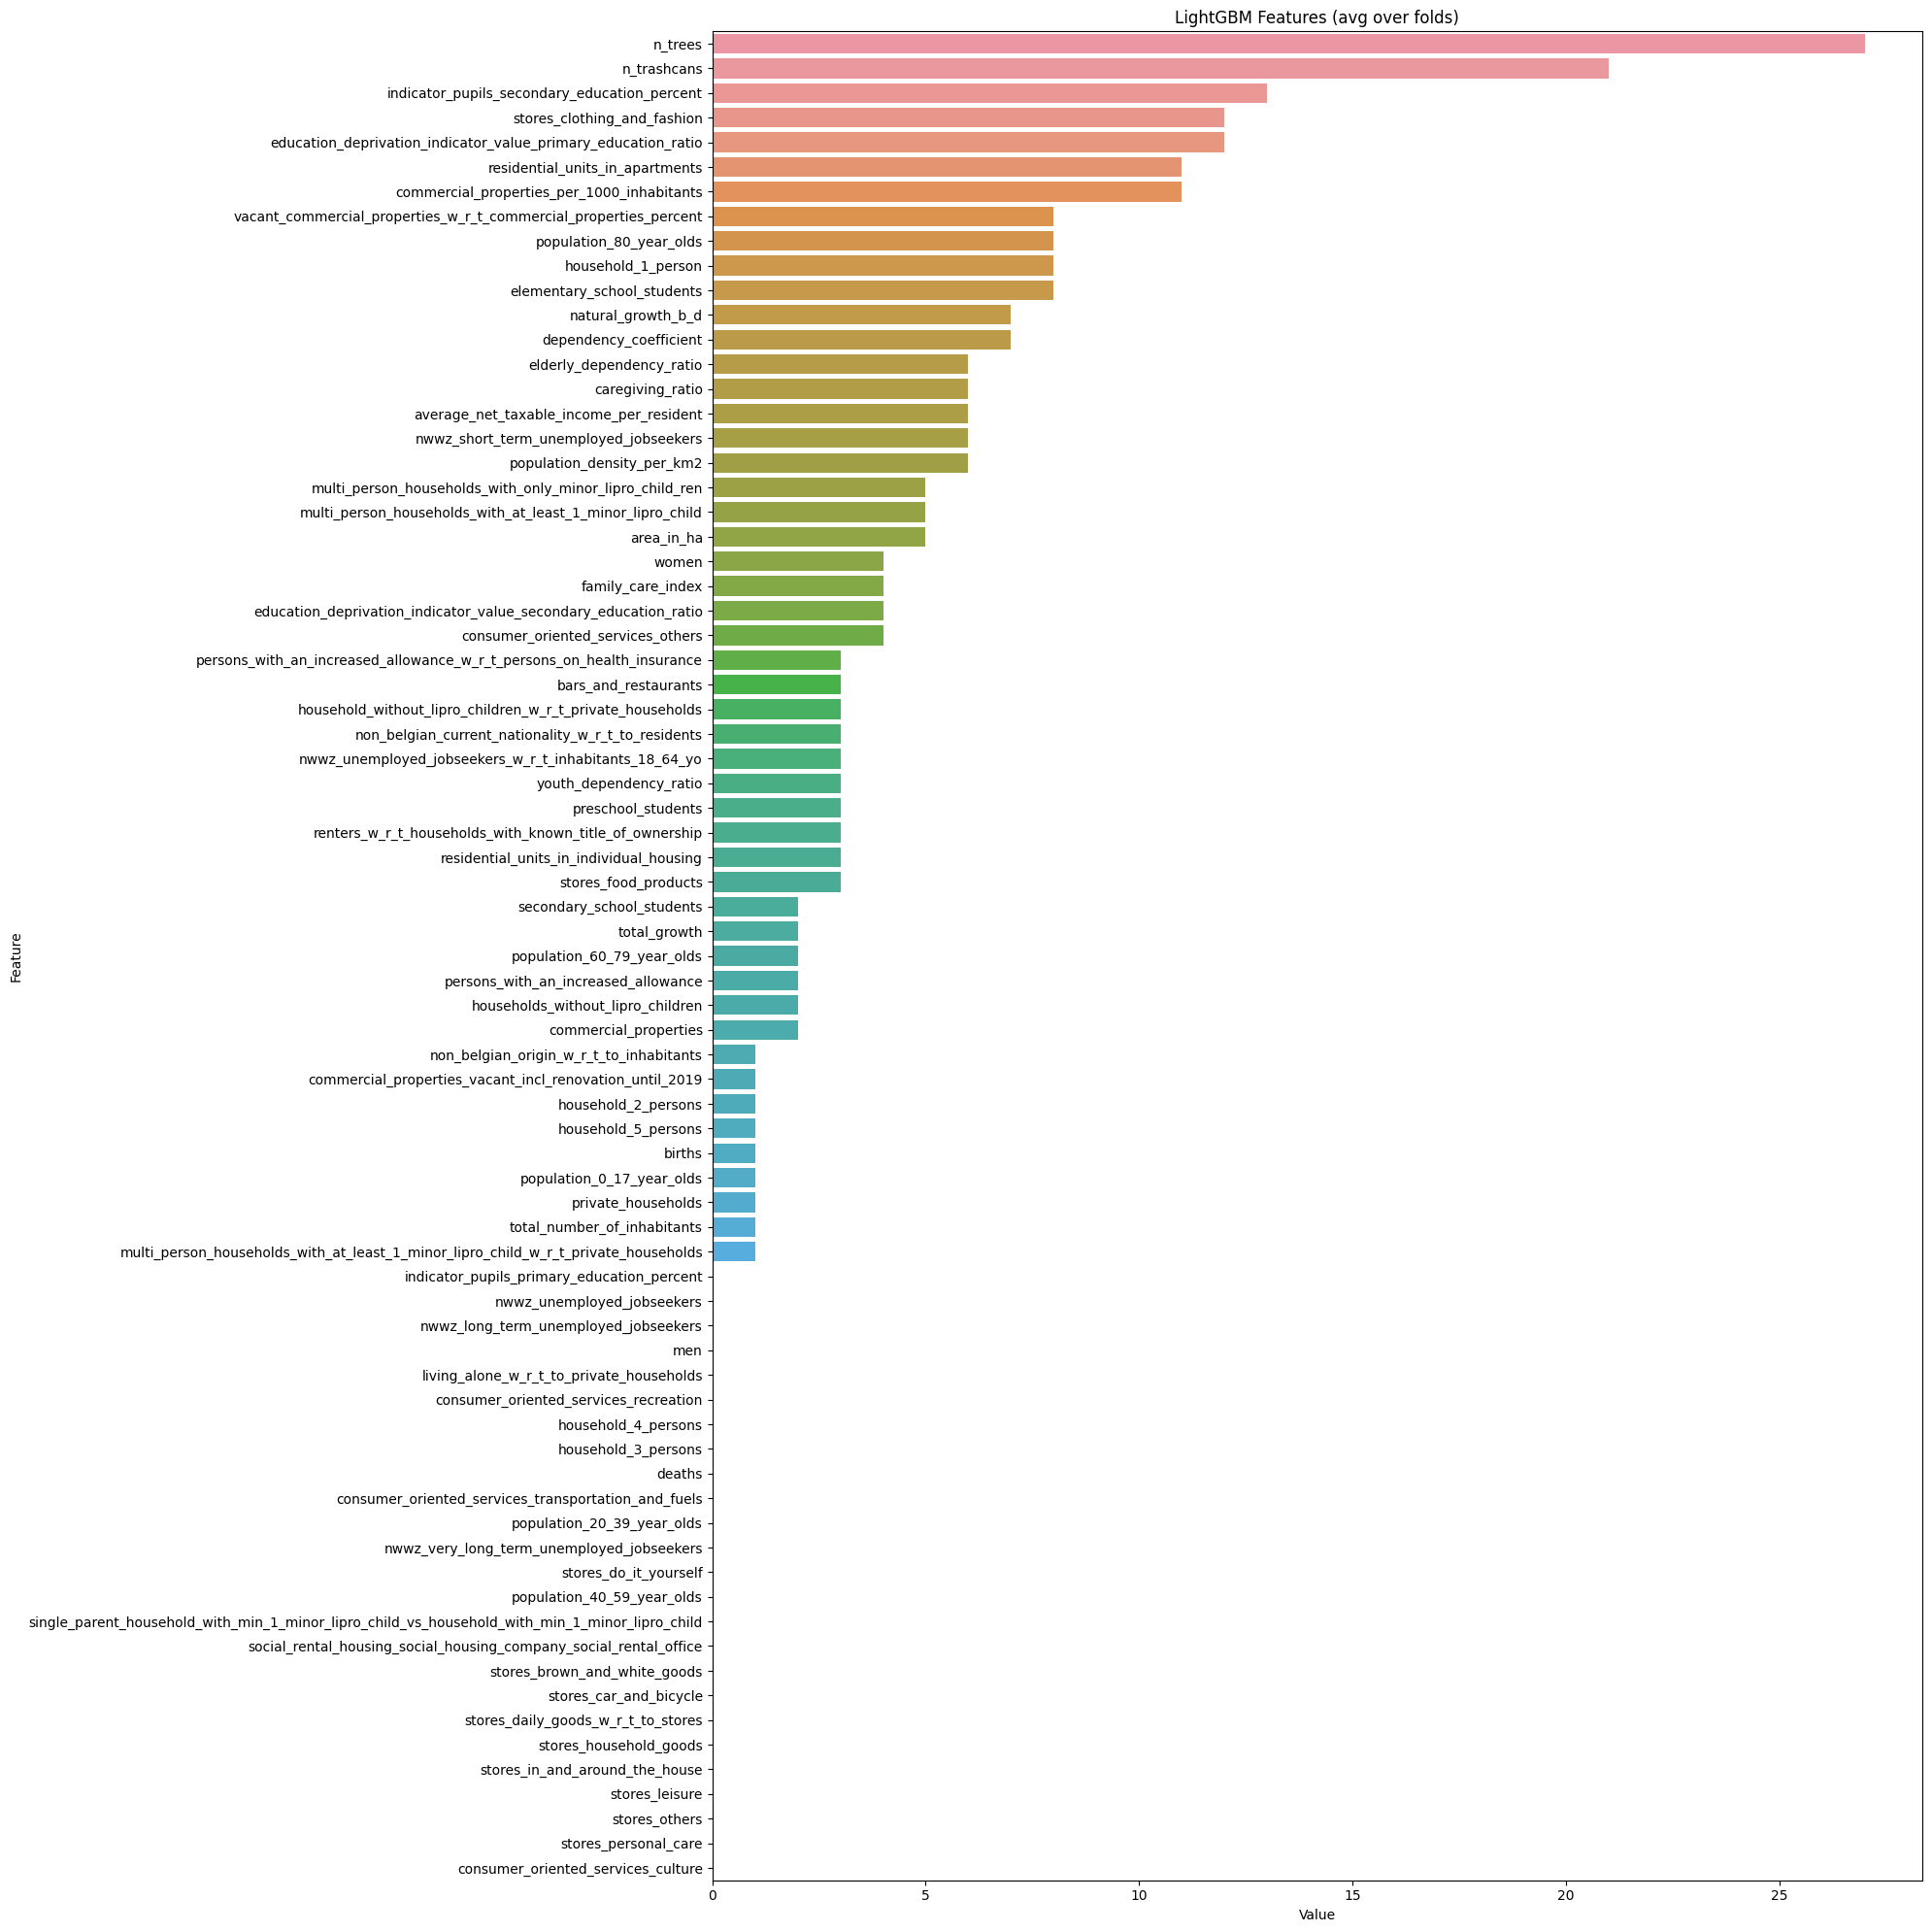

<Figure size 640x480 with 0 Axes>

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot_importance(model, max_num_features = 60, height=1)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')


In [241]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train)

Permutation explainer: 95it [00:58,  1.34it/s]                        


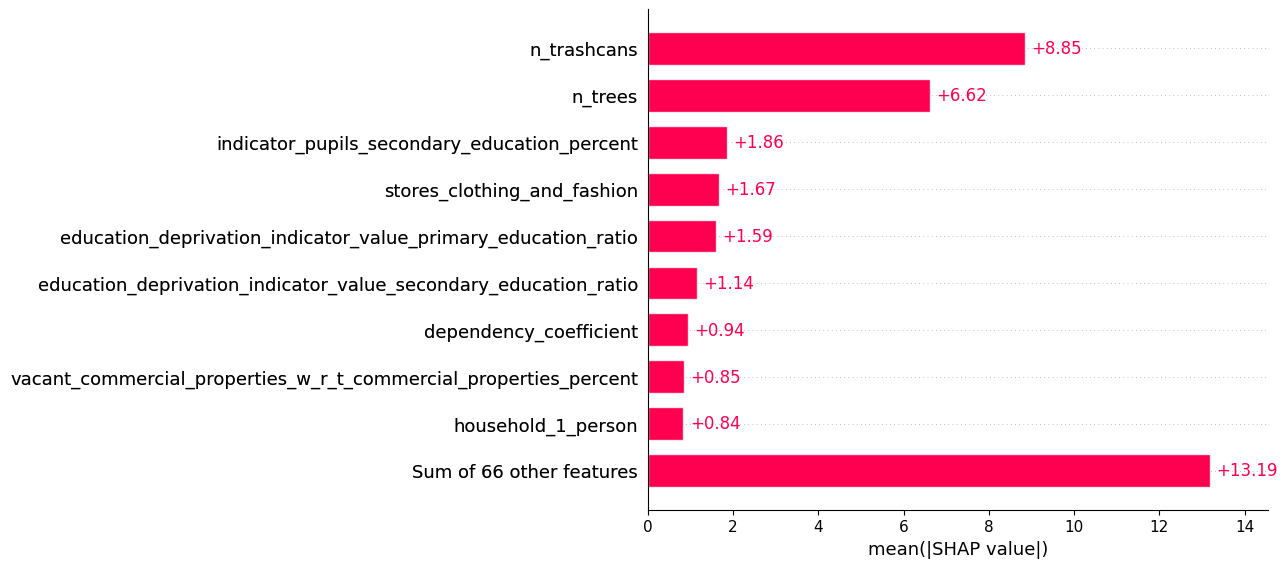

In [242]:
shap.plots.bar(shap_values)

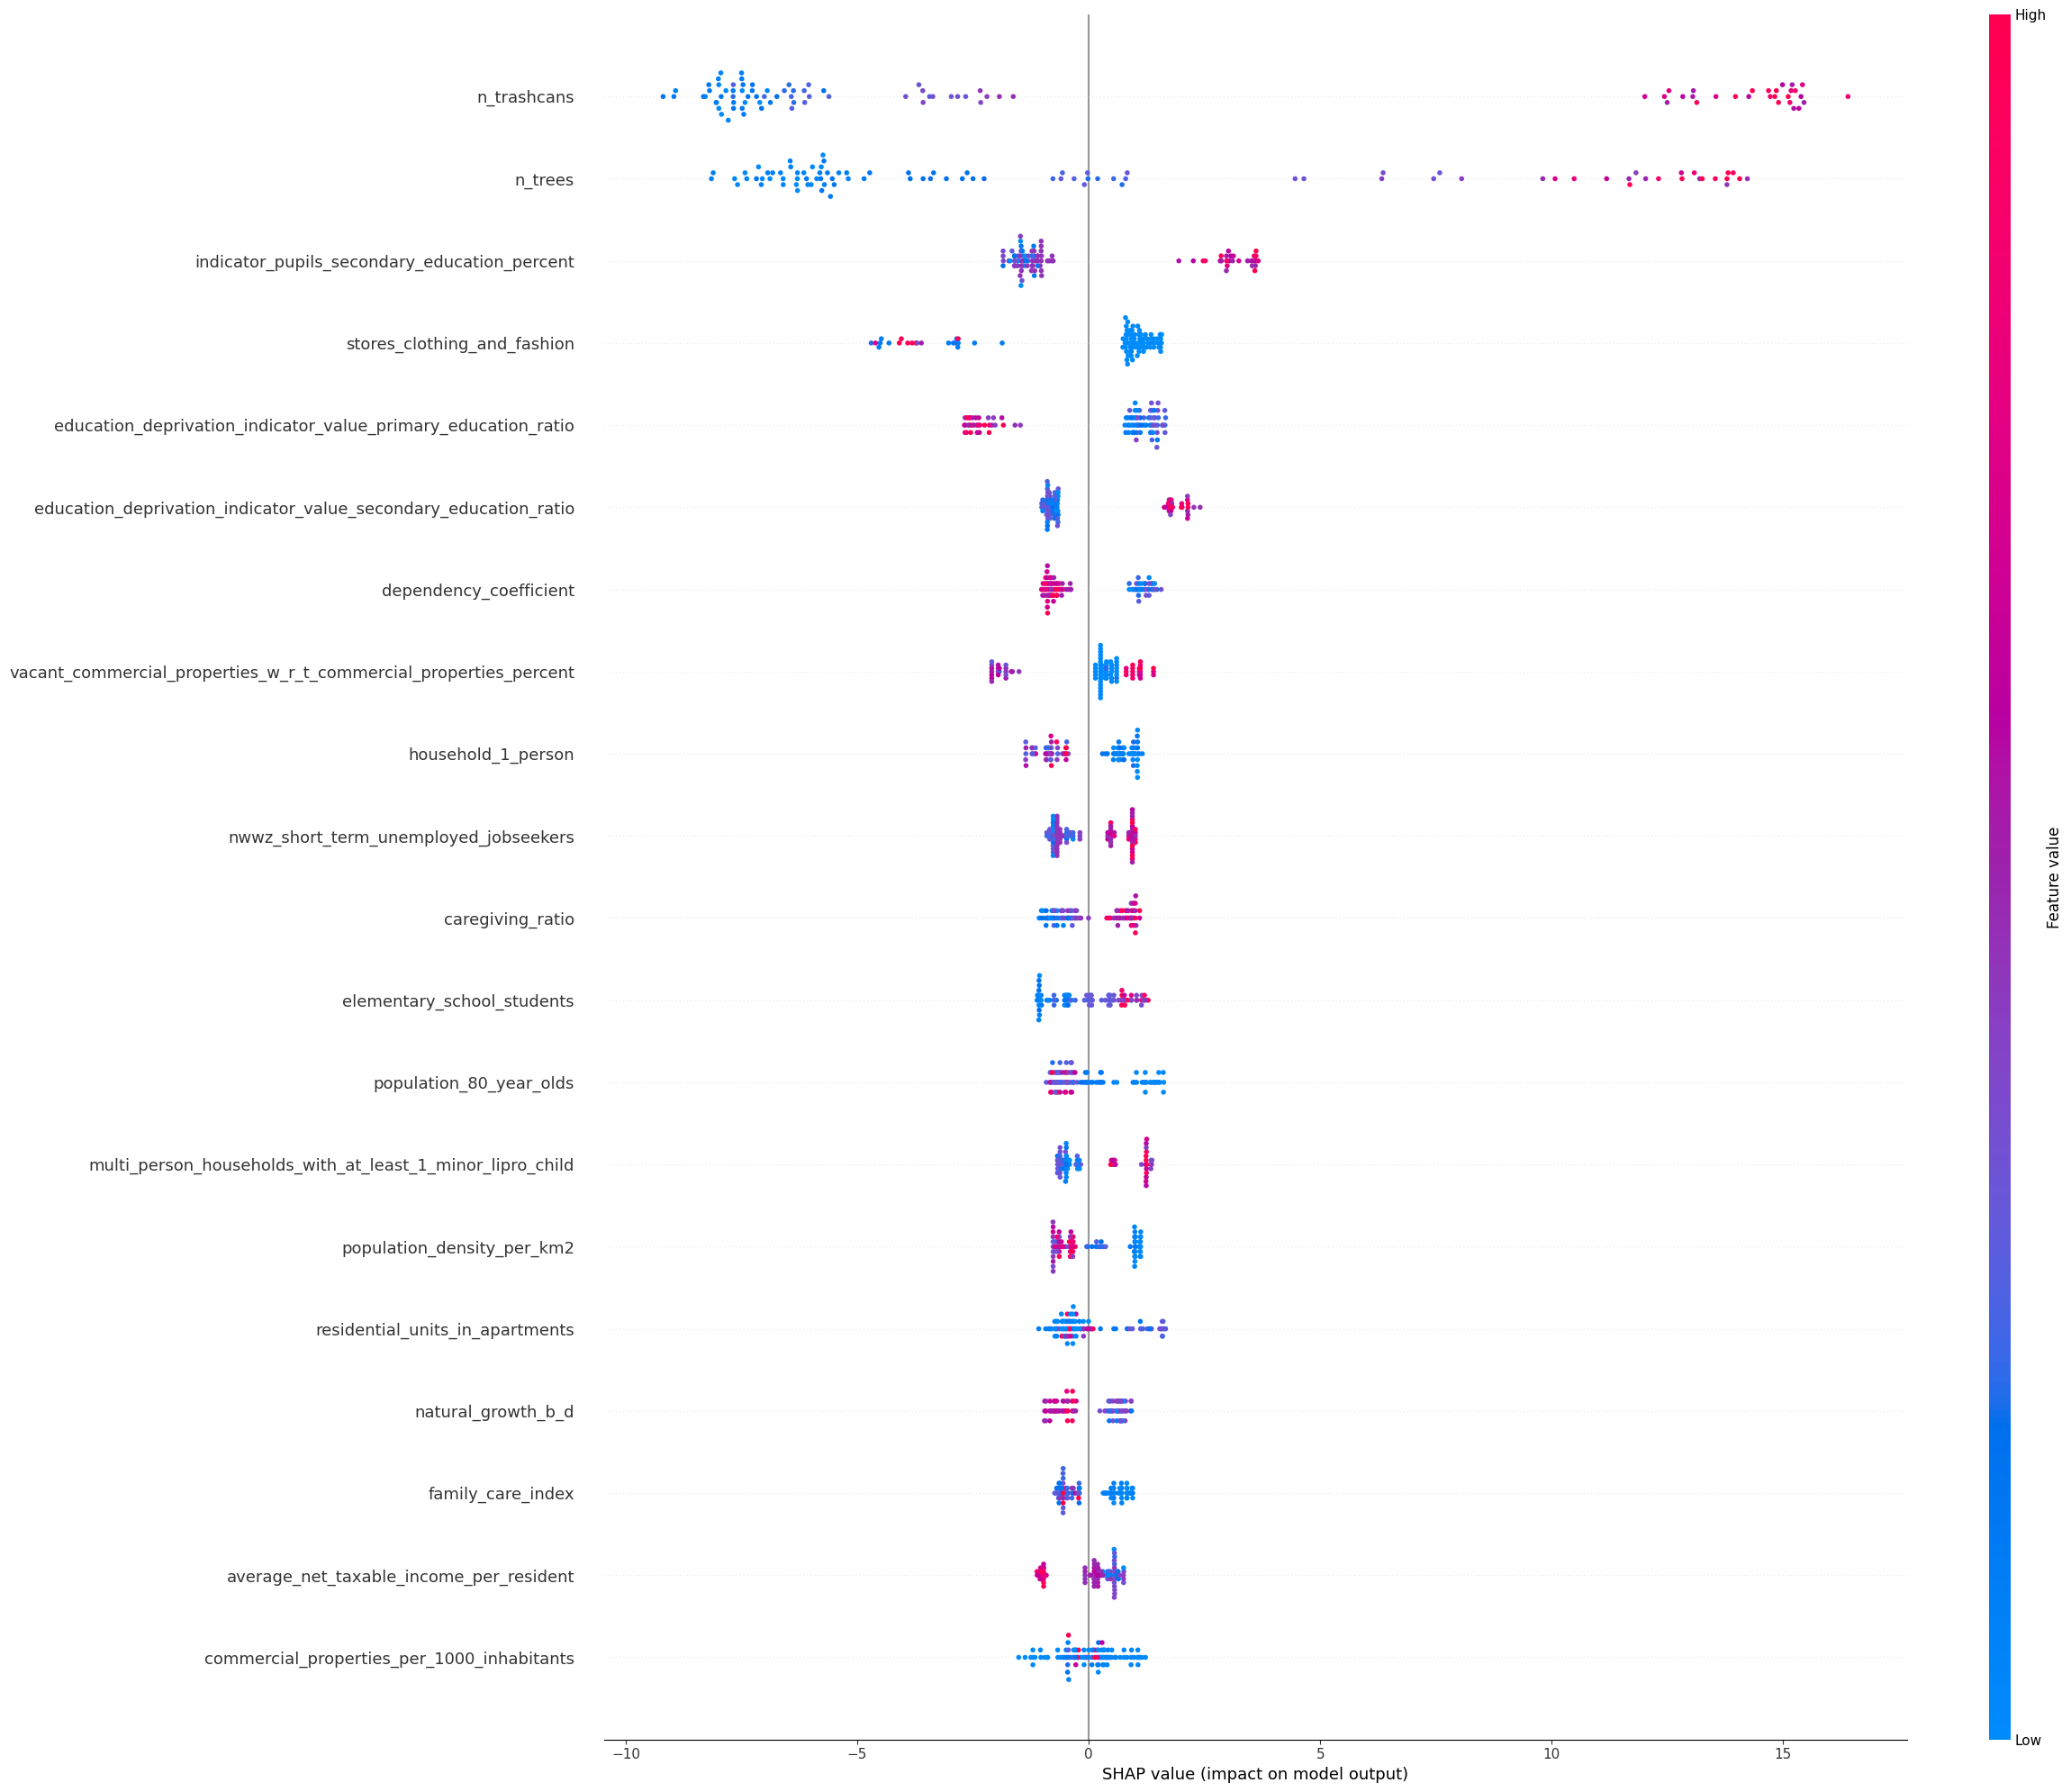

In [243]:
shap.summary_plot(shap_values, plot_size=(25,20))

# Mapping differences: Validation

In [244]:
scale = lambda col: abs((col-col.mean()).div(col.max()))

def mutateDF(df, keys, factors, nan_handlers):
	df['value'] = np.zeros(len(df_Geo))
	for index, key in enumerate(keys):
		df['temp'] = df[key].fillna(nan_handlers[index])
		df['temp'] = scale(df['temp'])*factors[index]
		df['value'] += df['temp']**2
	df['value'] *= abs(1-scale(df['n_benches'])**1.72)
	df['value'] = df['value'].div(df['value'].max()).fillna(0)
	df.plot('value', legend=True, legend_kwds={'label': "Difference",'orientation': "horizontal"}, figsize=(10,10))
	plt.show()

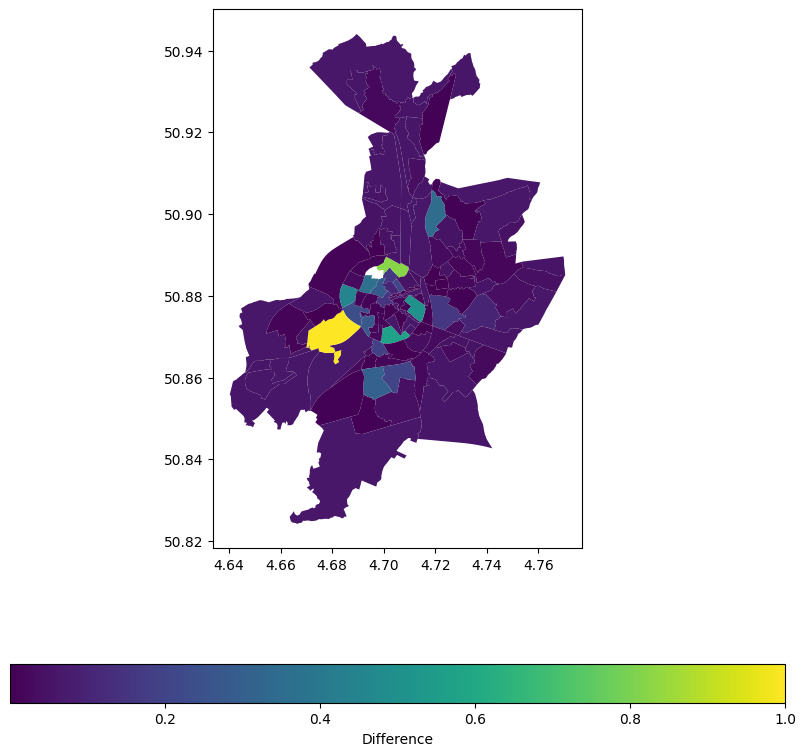

In [245]:
df = df_Geo.copy(deep=True)
df['FChanceperChild'] = (df_Geo['average_net_taxable_income_per_resident'].replace(np.nan, 0)/(df_Geo['youth_dependency_ratio']).fillna(df_Geo['youth_dependency_ratio'].median()))
df['FChanceperChild'] = df['FChanceperChild'].max() - df['FChanceperChild']
df['stores'] = df_Geo['stores_clothing_and_fashion'].fillna(0) + df_Geo['stores_food_products'].fillna(0)

keys = ['FChanceperChild', 'non_belgian_current_nationality_w_r_t_to_residents', 'stores','indicator_pupils_secondary_education_percent','residential_units_in_apartments']
# Play with these factors to give a different view on the city of Leuven and it's differences
# Setting multiple factors to non-zero combines different pieces of information in a clever way
factors = [0,0,0,0,1]
nan_handlers = [df['FChanceperChild'].median(), df['non_belgian_current_nationality_w_r_t_to_residents'].median(), 0, df['indicator_pupils_secondary_education_percent'].median(),0]

mutateDF(df, keys, factors, nan_handlers)

In the plot above, values close to zero indicate that these regions are very close to the average, whereas higher values indicate more differences. 

# Clustering: K-means

In [246]:
x_coor = pd.Series(df_Geo['geometry'].centroid.x, name="X")
y_coor = pd.Series(df_Geo['geometry'].centroid.y, name="Y")
coor = pd.concat([x_coor, y_coor], axis=1)

In [247]:
columns_to_use_clustering = ['n_trees', 'n_trashcans', 'indicator_pupils_secondary_education_percent', 'stores_clothing_and_fashion', 'education_deprivation_indicator_value_primary_education_ratio', 'residential_units_in_apartments', 'commercial_properties_per_1000_inhabitants', 'population_80_year_olds', 'household_1_person', 'elementary_school_students']

In [248]:
df_Geo_dropna = df_Geo.dropna(axis=1, thresh=50)
mean_columns = ['total_number_of_inhabitants', 'population_density_per_km2', 'men', 'women', 'population_0_17_year_olds', 'population_20_39_year_olds', 'population_40_59_year_olds', 'population_60_79_year_olds', 'population_80_year_olds', 'births', 'deaths', 'elderly_dependency_ratio', 'youth_dependency_ratio', 'caregiving_ratio', 'dependency_coefficient', 'family_care_index', 'non_belgian_current_nationality_w_r_t_to_residents', 'non_belgian_origin_w_r_t_to_inhabitants', 'private_households', 'households_without_lipro_children', 'multi_person_households_with_at_least_1_minor_lipro_child', 'multi_person_households_with_only_minor_lipro_child_ren', 'household_1_person', 'household_2_persons', 'household_3_persons', 'household_4_persons', 'household_5_persons', 'living_alone_w_r_t_to_private_households', 'household_without_lipro_children_w_r_t_private_households', 'multi_person_households_with_at_least_1_minor_lipro_child_w_r_t_private_households', 'single_parent_household_with_min_1_minor_lipro_child_vs_household_with_min_1_minor_lipro_child', 'nwwz_unemployed_jobseekers_w_r_t_inhabitants_18_64_yo', 'nwwz_unemployed_jobseekers', 'nwwz_short_term_unemployed_jobseekers', 'nwwz_long_term_unemployed_jobseekers', 'nwwz_very_long_term_unemployed_jobseekers', 'renters_w_r_t_households_with_known_title_of_ownership', 'persons_with_an_increased_allowance', 'persons_with_an_increased_allowance_w_r_t_persons_on_health_insurance', 'average_net_taxable_income_per_resident', 'preschool_students', 'elementary_school_students', 'secondary_school_students', 'indicator_pupils_primary_education_percent', 'indicator_pupils_secondary_education_percent', 'education_deprivation_indicator_value_primary_education_ratio', 'education_deprivation_indicator_value_secondary_education_ratio', 'geometry']

zero_columns = ['commercial_properties', 'commercial_properties_per_1000_inhabitants', 'stores_food_products', 'stores_personal_care', 'stores_clothing_and_fashion', 'stores_household_goods', 'stores_leisure', 'stores_in_and_around_the_house', 'stores_brown_and_white_goods', 'stores_car_and_bicycle', 'stores_do_it_yourself', 'stores_others', 'bars_and_restaurants', 'consumer_oriented_services_culture', 'consumer_oriented_services_transportation_and_fuels', 'consumer_oriented_services_recreation', 'consumer_oriented_services_others', 'commercial_properties_vacant_incl_renovation_until_2019', 'vacant_commercial_properties_w_r_t_commercial_properties_percent', 'stores_daily_goods_w_r_t_to_stores', 'residential_units_in_apartments', 'residential_units_in_individual_housing']

df_fillna = df_Geo_dropna
df_fillna[mean_columns] = df_Geo_dropna[mean_columns].fillna(df_Geo_dropna[mean_columns].mean())
df_fillna[zero_columns] = df_Geo_dropna[zero_columns].fillna(0)

X_no_nans = df_fillna.drop(labels =["n_benches", "geometry", "statistical_sector"], axis=1)

In [249]:
X = pd.concat([coor, X_no_nans[columns_to_use_clustering]], axis=1)
X.drop(71, axis=0, inplace=True) # Row 71 has no X and Y coor
display(X)

,X,Y,n_trees,n_trashcans,indicator_pupils_secondary_education_percent,stores_clothing_and_fashion,education_deprivation_indicator_value_primary_education_ratio,residential_units_in_apartments,commercial_properties_per_1000_inhabitants,population_80_year_olds,household_1_person,elementary_school_students
0,4.653820,50.871052,363,3,0.420512,0.0,0.42000,0.0,10.99,11.00000,11.000000,17.00000
1,4.688854,50.875852,561,51,0.449000,0.0,0.84000,1295.0,6.45,74.00000,834.000000,70.00000
2,4.715330,50.906038,13,0,0.420512,0.0,0.50000,0.0,15.38,7.00000,217.283186,7.00000
3,4.723311,50.875958,558,16,0.363000,1.0,0.58000,749.0,6.52,140.00000,593.000000,220.00000
4,4.729917,50.900495,437,14,0.419000,0.0,0.92000,203.0,6.52,103.00000,302.000000,163.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
113,4.697274,50.892103,123,10,0.438000,0.0,1.85000,296.0,6.48,48.00000,205.000000,70.00000
114,4.701458,50.893304,16,3,0.154000,0.0,0.34000,34.0,3.38,54.00000,114.000000,34.00000
115,4.763481,50.887407,103,0,0.222000,0.0,0.51000,14.0,12.46,17.00000,37.000000,28.00000
116,4.734623,50.867354,83,3,0.420512,0.0,0.25000,21.0,30.86,16.00000,40.000000,34.00000


In [250]:
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

In [251]:
model = KMeans(n_clusters=15)

In [252]:
model.fit(X_train)

KMeans(n_clusters=15)

In [253]:
model.cluster_centers_

array([[4.70808323e+00, 5.08800160e+01, 5.80000000e+01, 1.56666667e+01,
        5.39674419e-01, 3.16666667e+01, 1.52333333e+00, 4.38333333e+02,
        3.39753333e+02, 1.40000000e+01, 1.88333333e+02, 2.43018868e+01],
       [4.70057444e+00, 5.08785573e+01, 3.49400000e+02, 2.72000000e+01,
        5.16600000e-01, 4.00000000e-01, 1.66800000e+00, 1.26480000e+03,
        1.47040000e+01, 6.56000000e+01, 7.52200000e+02, 7.44000000e+01],
       [4.68164455e+00, 5.08633922e+01, 3.70500000e+03, 3.60000000e+01,
        4.20511628e-01, 0.00000000e+00, 9.55370370e-01, 6.45000000e+02,
        1.20900000e+01, 5.35049505e+01, 5.46000000e+02, 5.59056604e+01],
       [4.70846601e+00, 5.08942602e+01, 2.65000000e+02, 2.20000000e+01,
        4.20511628e-01, 0.00000000e+00, 9.55370370e-01, 0.00000000e+00,
        2.75000000e+03, 5.35049505e+01, 2.17283186e+02, 5.59056604e+01],
       [4.70476839e+00, 5.08890755e+01, 8.19090909e+01, 4.72727273e+00,
        3.50368922e-01, 9.09090909e-02, 6.17584175e-01, 1.25

In [254]:
coordinates = []
for i in range(15):
    coordinates.append((model.cluster_centers_[i][0], model.cluster_centers_[i][1]))
print(coordinates)

[(4.708083232936639, 50.88001595095783), (4.700574443130451, 50.878557321642596), (4.681644546887188, 50.86339223002354), (4.708466005108738, 50.89426018443936), (4.704768394665881, 50.88907551236522), (4.709651764435892, 50.88270563081012), (4.706457292150375, 50.88021072622604), (4.722853795528767, 50.8868162267108), (4.679836346762435, 50.870580956610326), (4.715983867113845, 50.87169632860399), (4.70371251671434, 50.900319620070164), (4.713791828797705, 50.88320447646124), (4.707052181203634, 50.87647554134153), (4.723310948576552, 50.875958252404516), (4.701339653112009, 50.876120622677874)]
